<a href="https://colab.research.google.com/github/pnrdgp/SAIL-Bhilai-Steel-Plant-Project/blob/main/SAIL_BSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import sys


In [4]:
try:
    # Use the filename directly after uploading it to the Colab environment
    df = pd.read_csv('blastfurnacedata.csv', encoding='utf-8-sig')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'blastfurnacedata.csv' not found. Please upload the file to the Colab environment.")
    sys.exit()

df.head()


Dataset loaded successfully.


,fuel rate,moisture,co efficiency,hot blast temp,slag rate,flame temp,top pressure
0,573.0,4.0,46.200000,1140.00,453,2195.3,2.24
1,568.6,4.0,46.351058,1162.79,510,2253.9,2.26
2,576.6,4.0,45.250000,1170.00,514,2248.2,2.33
3,556.6,4.0,46.193430,1152.00,492,2188.7,2.36
4,593.4,4.0,43.620000,1111.79,492,2219.9,2.45


In [5]:
# Rename Columns
df = df.rename(columns={
    'ï»¿fuel rate': 'fuel_rate',
    'fuel rate': 'fuel_rate',
    'moisture': 'moisture',
    'co efficiency': 'co_efficiency',
    'hot blast temp': 'hot_blast_temp',
    'slag rate': 'slag_rate',
    'flame temp': 'flame_temp',
    'top pressure': 'top_pressure'
})

print("Columns renamed successfully.")

# Validate and Clean Columns
required_cols = ['moisture', 'co_efficiency', 'hot_blast_temp',
                 'slag_rate', 'flame_temp', 'top_pressure', 'fuel_rate']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"\nMissing Columns: {missing_cols}. Please check your dataset.")
    sys.exit()

df[required_cols] = df[required_cols].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=required_cols, inplace=True)
print("\nData types converted and missing values removed.")
print(f"Data shape after cleaning: {df.shape}")


Columns renamed successfully.

Data types converted and missing values removed.
Data shape after cleaning: (234, 7)


In [6]:
Q1 = df[required_cols].quantile(0.25)
Q3 = df[required_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[required_cols] < (Q1 - 1.5 * IQR)) | (df[required_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Data shape after outlier removal: {df.shape}")


Data shape after outlier removal: (209, 7)


In [7]:
fig = px.imshow(df[required_cols].corr(), text_auto=True,
                title="Correlation Heatmap", color_continuous_scale='RdBu_r')
fig.show()

In [8]:
features = ['moisture', 'co_efficiency', 'hot_blast_temp',
            'slag_rate', 'flame_temp', 'top_pressure']

for feature in features:
    fig = px.scatter(df, x=feature, y='fuel_rate',
                     trendline="ols",
                     title=f'{feature.replace("_", " ").title()} vs Fuel Rate',
                     labels={feature: feature.replace('_', ' ').title(), 'fuel_rate': 'Fuel Rate'},
                     color_discrete_sequence=['dodgerblue'])
    fig.show()


In [9]:
X = df[features]
y = df['fuel_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

print("Data split into training and testing sets.")

Data split into training and testing sets.


In [10]:
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

print("\nTuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=5, scoring='r2', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)


Tuning Random Forest...
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

Tuning Gradient Boosting...
Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest (Tuned)': rf_grid.best_estimator_,
    'Gradient Boosting (Tuned)': gb_grid.best_estimator_
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'MSE': mse, 'R2 Score': r2})
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

Linear Regression - MSE: 207.47, R2: 0.27
Decision Tree - MSE: 297.89, R2: -0.05
Random Forest (Tuned) - MSE: 165.81, R2: 0.42
Gradient Boosting (Tuned) - MSE: 198.09, R2: 0.30


In [12]:
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:\n", results_df)

fig = px.bar(results_df, x='Model', y='R2 Score', color='Model', text='R2 Score',
             title='Model Performance Comparison (R² Score)',
             labels={'R2 Score': 'R² Score'})
fig.show()



Model Evaluation Results:
                        Model         MSE  R2 Score
0          Linear Regression  207.469673  0.270912
1              Decision Tree  297.893016 -0.046853
2      Random Forest (Tuned)  165.814301  0.417297
3  Gradient Boosting (Tuned)  198.086702  0.303886


The best model selected is: RandomForestRegressor


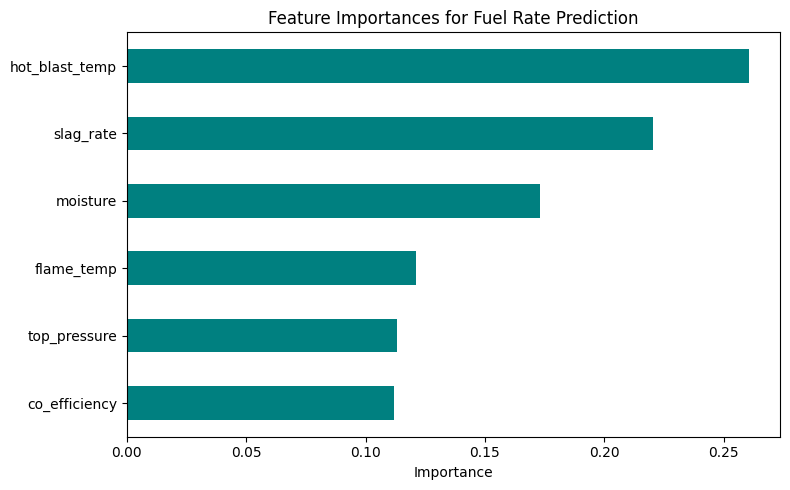

In [13]:
best_model = rf_grid.best_estimator_
print(f"The best model selected is: {type(best_model).__name__}")

importances = pd.Series(best_model.feature_importances_, index=features)
plt.figure(figsize=(8, 5))
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Feature Importances for Fuel Rate Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [14]:
def get_user_input():
    inputs = {}
    print("\nPlease enter the following values to predict the fuel rate:")
    for feature in features:
        while True:
            try:
                value = float(input(f"Enter {feature.replace('_', ' ')}: "))
                inputs[feature] = value
                break
            except ValueError:
                print("Invalid input. Please enter a numeric value.")
    return pd.DataFrame([inputs])

# Example new data for prediction
example_new_data = pd.DataFrame([
    {'moisture': 5.0, 'co_efficiency': 50.0, 'hot_blast_temp': 1200.0,
     'slag_rate': 250.0, 'flame_temp': 2000.0, 'top_pressure': 1.5}
])

predicted_fuel_rate = best_model.predict(example_new_data)
print("\nPredicted Fuel Rate for New Data:", predicted_fuel_rate[0])



Predicted Fuel Rate for New Data: 574.4922215367967


In [15]:
model_path = 'fuel_rate_rf_model.pkl'
joblib.dump(best_model, model_path)
print(f"\nModel saved as '{model_path}'")

df.to_csv('cleaned_blast_furnace_data.csv', index=False)
print("Cleaned data saved as 'cleaned_blast_furnace_data.csv'")


Model saved as 'fuel_rate_rf_model.pkl'
Cleaned data saved as 'cleaned_blast_furnace_data.csv'
